# Chapter 7 Regression and other stories.

### Simple regression


In [1]:
#Import relvant analyis and visualition packages.
import pystan as ps
import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
url = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat"
df = pd.read_table(url, sep = " ")
df.head(2)

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson


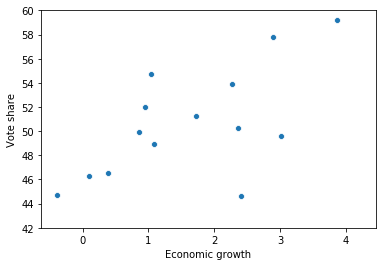

In [58]:
#Plotting data
sns.scatterplot(x = "growth",  y = "vote", data = df,)
plt.ylim(42, 60)
plt.xlabel("Economic growth");
plt.ylabel("Vote share");

# Stan model

In [15]:
#Simple Regressiom
M1 = """

data{

int<lower = 0> N; // Number of data points

vector[N] Y; // Vector of the dependent variable

vector[N] X; // Vecroe of Independent variable 

}

parameters{

real alpha; // Intercept term

real beta; // Slope term

real<lower = 0> sigma; // Error (epsilon)

}

transformed parameters {

vector[N] mu;

mu = alpha + X * beta;

}

model{

//Priors

//likelihood
Y ~ normal(mu, sigma);

}
"""

In [16]:
sm = ps.StanModel(model_code=M1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_69e06386c27d53a4e0b4d885ecd55f40 NOW.


In [27]:
# Python dictionart for imputing the data.

data = {"N": len(df),
       "Y": df["vote"].values,
       "X": df["growth"].values}

In [53]:
fit_M1 = sm.sampling(data = data, iter = 10000, seed = 7487483)

### Stan model output

In [51]:
# Currently in pystan printing models with large numbers of parmaeters looks bad as cannot only specify the few to be printed.
#print(fit_M1)

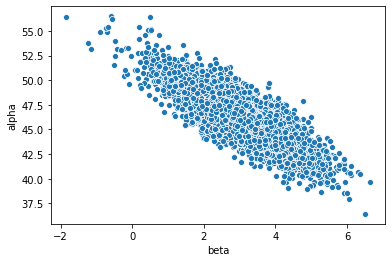

In [56]:
fit_M1_df = pd.DataFrame(fit_M1.extract(pars = ["beta", "alpha", "sigma"]));
sns.scatterplot(x = "beta", y = "alpha" , data = fit_M1_df)

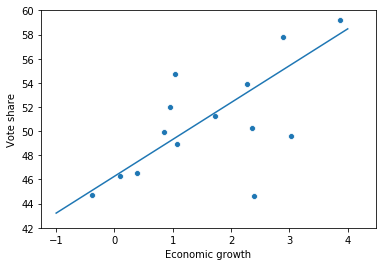

In [184]:
# Scaterplot with the MAP estimates for the linear model fit above 
sns.scatterplot(x = "growth",  y = "vote", data = df,)
plt.ylim(42, 60)
plt.xlabel("Economic growth");
plt.ylabel("Vote share");
x_vals = np.arange(start=-1, stop=5, step=1)
y_vals = np.mean(fit["alpha"]) + np.mean(fit["beta"]) * x_vals
plt.plot(x_vals, y_vals, '-')

Checking the model with fake data,

In [110]:
a =  np.median(fit["alpha"])
b = np.median(fit["beta"])
sigma = np.median(fit["sigma"]) 
x = df["growth"].values
n = len(df)

In [111]:
# simulate fake data

y = a + b*x + np.random.normal(loc = 0, scale = sigma, size = n)

# Put data into the dataframe. 
d = {'x': x, 'y': y}

fake = pd.DataFrame(d)


Fitting the linear model to simualted fake data

In [112]:
# Generate new python dictionary for the simulated fake data.

fake_data = {"N": len(fake),
             "X": fake["x"].values,
             "Y": fake["y"].values}


#Fit the stan model from above to the simulated data.

fake_fit = sm.sampling(data=fake_data, iter = 10000, seed = 7487483)

In [158]:
# Exractinting model summary values 
s_fit = fit.summary(pars= ["alpha", "beta", "sigma"])
summary_fit = pd.DataFrame(s_fit['summary'], columns=s['summary_colnames'], index=s['summary_rownames'])
summary_fit

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,46.267247,0.022095,1.861425,42.576518,45.081533,46.267291,47.429040,49.979502,7097.191187,1.000610
beta,3.050577,0.009498,0.798781,1.458481,2.545804,3.049473,3.565150,4.620833,7073.176728,1.000291
sigma,4.169818,0.009841,0.913433,2.837393,3.534579,4.015864,4.639178,6.379444,8615.344038,1.000290


In [176]:
# Comapre the model fits to simualted fake data
b_hat = summary_fit.iloc[1,0]
b_se = summary_fit.iloc[1,1]

#cover_68 = np.abs(b - b_hat) < b_sd
#cover_95 = np.abs(b - b_hat) < 2 * b_sd

In [179]:
# How se_mean in calculated. I.E. the Standard deviation of the estimated paramerter divided by the the sqrt of the effective 
# samples.
np.std(fit["beta"])/(np.sqrt(summary_fit.iloc[1,8]))

0.009497501491853555

# Default priors (Based on data) model from Rstanarm formulatio in stan code

In [22]:
M1a = """

data{

int<lower = 0> N; // Number of data points

vector[N] Y; // Vector of the dependent variable

vector[N] X; // Vecroe of Independent variable 

}

transformed data{

real std_Y;
real std_X;
real mean_Y;

std_Y = sd(Y);
std_X = sd(X);
mean_Y = mean(Y);

}

parameters{

real alpha; // Intercept term

real beta; // Slope term

real<lower = 0> sigma; // Error (epsilon) term

}

transformed parameters {

vector[N] mu;

mu = alpha + X * beta;

}

model{

//Priors
alpha ~ normal(mean_Y, 2.5 * std_Y); // Default prior using a mean of 0 and SD se

beta ~ normal(0, 2.5 * std_Y/std_X);

sigma ~ exponential(1/std_Y);


//likelihood
Y ~ normal(mu, sigma);

}
"""

In [25]:
sm_M1a = ps.StanModel(model_code = M1a)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4dbf6ddc9ad767876a62fde6d47970bd NOW.


In [60]:
fit_M1a = sm_M1a.sampling(data = data, iter = 10000, seed = 7487483)

In [73]:
#print(fit_M1a)

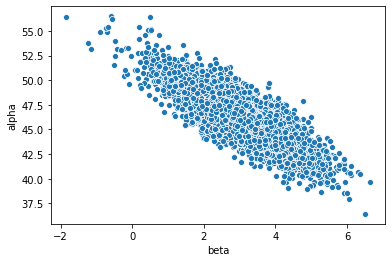

In [62]:
fit_M1a_df = pd.DataFrame(fit_M1a.extract(pars = ["beta", "alpha", "sigma"]))
sns.scatterplot(x = "beta", y = "alpha" , data = fit_M1_df)

### Weakly informative prior bistribution with subject knowledge

In [45]:
M4 = """

data{

int<lower = 0> N; // Number of data points

vector[N] Y; // Vector of the dependent variable

vector[N] X; // Vecroe of Independent variable 

}

transformed data{

real std_Y;
std_Y = sd(Y);
}

parameters{

real alpha; // Intercept term

real beta; // Slope term

real<lower = 0> sigma; // Error (epsilon)

}

transformed parameters {

vector[N] mu;

mu = alpha + X * beta;

}

model{

//Priors

alpha ~ normal(50, 10);
beta ~ normal(5,5);
sigma ~ exponential(1/std_Y);

//likelihood
Y ~ normal(mu, sigma);

}
"""

In [46]:
sm_M4 = ps.StanModel(model_code = M4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_06556c30778d84612c9bdab200a69425 NOW.


In [47]:
fit_M4 = sm_M4.sampling(data = data, iter = 10000, seed = 7487483)

In [64]:
#print(fit_M4)

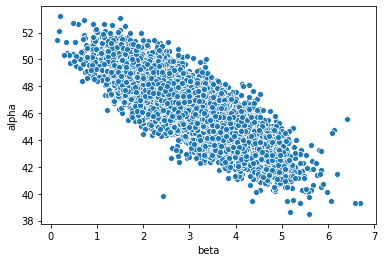

In [70]:
fit_M4_df = pd.DataFrame(fit_M4.extract(pars = ["beta", "alpha", "sigma"]))
sns.scatterplot(x = "beta", y = "alpha" , data = fit_M4_df)